# Comment générer un modèle numérique d'élévation (MNE) à partir d'un nuage de point lidar en format COPC LAZ

Ce tutoriel donne des exemples permettant de générer un [modèle numérique d'élévation](https://natural-resources.canada.ca/maps-tools-and-publications/satellite-imagery-elevation-data-and-air-photos/elevation-data/24975) à partir d'un nuage de point lidar du produit [Nuages de points lidars - Série CanÉlévation](https://ouvert.canada.ca/data/fr/dataset/7069387e-9986-4297-9f55-0288e9676947). Nous utiliserons principalement la librairie [pdal](https://pdal.io/en/2.8.3/index.html) pour préparer les points et générer la grille matricielle.
Plus spécifiquement, nous allons créer un modèle numérique de terrain. Ce modèle est une grille matricielle dont chaque pixel représente une valeur d'altitude du sol à cet endroit.
La création de ce modèle se fait en trois étapes distinctes.

1. Lire les points.
2. Filtrer les points pour garder seulement ceux ayant la classe sol (classe 2 et 9).
3. Générer une grille matricielle.

## Étapes:

1) [Préparer l'environnement](#env)

2) [Importer les modules nécessaires](#import)

3) [Définir les variables](#definir-var)

4) [Définir les méthodes](#definir-meta)

5) [Filtrer les points en préparation à la création du MNE](#filter-points)

6) [Créer le MNE au format GeoTIFF](#creer-mne)


<a id="env"></a>
## 1) Préparer l'environnement

Pour exécuter ces exemples localement, suivez les étapes suivantes :

### 1.1) Récupérer le code source

   Dans le répertoire de votre choix sur votre ordinateur, clonez le dépôt en utilisant la commande suivante :
   >```bash
   >git clone https://github.com/NRCan/CanElevation.git
   >```
   
   Ensuite, accédez au répertoire contenant les notebooks :
   >```bash
   >cd CanElevation/docs/fr/pointclouds
   >```

### 1.2) Installation conda

   Nous recommandons d’utiliser conda pour gérer les dépendances.
   
   Si vous ne l’avez pas encore installé, consultez les [instructions officielles d’installation de Miniconda](https://docs.anaconda.com/miniconda/install/#quick-command-line-install). Les étapes suivantes supposent que conda est accessible depuis votre ligne de commande.

### 1.3) Installation des dépendances

   Le fichier `docs\assets\env\environment.yml` contient toutes les dépendances nécessaires. Créez un nouvel environnement conda à l’aide de la commande suivante :
   >```bash
   >conda env create -n CanElevation_PointClouds --file docs/assets/env/environment.yml
   >```
   
   Ensuite, activez le nouvel environnement créé :
   >```bash
   >conda activate CanElevation_PointClouds
   >```

### 1.4) Démarrer Jupyter Notebook

   Pour démarrer Jupyter Notebook, exécutez :
   >```bash
   >jupyter notebook
   >```

Si vous rencontrez des problèmes ou souhaitez explorer d'autres options de lancement, consultez le [guide utilisateur de Jupyter Notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html).

**Vous êtes maintenant prêt à exécuter les cellules de code du notebook.**

<a id="import"></a>
## 2) Importer les modules nécessaires

Dans l'exemple suivant, nous utilisons spécifiquement le module [PDAL](https://pdal.io/en/2.8.4/) pour créer le MNE. Nous utilisons également les modules [matplotlib](https://matplotlib.org/stable/) et [rasterio](https://rasterio.readthedocs.io/en/stable/index.html) à des fins de visualisation.

In [1]:
import os
import json
import pdal
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<a id="definir-var"></a>
## 3) Définir les variables

Pour cet exemple, nous utiliserons une tuile lidar de la région de Niagara en Ontario. Pour simplifier le traitement, nous définissons un polygone englobant à l’intérieur de cette tuile.

Ces variables peuvent être ajustées selon les besoins. Vous pouvez également utiliser [l’index des projets](https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/Index_LiDARprojects_projetslidar.zip) et [l’index des tuiles](https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/Index_LiDARtiles_tuileslidar.zip) du produit pour sélectionner une autre zone d’intérêt.

In [2]:
# URL du fichier LAZ COPC (Cloud Optimized Point Cloud) provenant du jeu de données lidar Hamilton-Niagara 2021
copc_laz = "https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/NRCAN/Hamilton_Niagara_2021_2/ON_Niagara_20210525_NAD83CSRS_UTM17N_1km_E656_N4771_CLASS.copc.laz"

# Nom du fichier local pour enregistrer tous les points non filtrés extraits du fichier COPC
all_points_laz = "niagara_unfiltered_points.laz"

# Nom du fichier local pour enregistrer uniquement les points classés comme sol/eau extraits du fichier COPC
ground_laz = "niagara_ground_points.laz"

# Zone d’intérêt (AOI) utilisée pour filtrer spécifiquement les points ; les coordonnées sont en NAD83(CSRS) - UTM zone 17N (EPSG:2958)
aoi_bbox = {
    'minx': 656083,     # coordonnée X minimale (est)
    'miny': 4771150,    # coordonnée Y minimale (nord)
    'maxx': 656722,     # coordonnée X maximale (est)
    'maxy': 4771614     # coordonnée Y maximale (nord)
}

<a id="definir-meta"></a>
## 4) Définir les méthodes

Nous définissons plusieurs méthodes utilisées pour traiter les données.

*Consultez la docstring de chaque méthode pour plus de détails sur sa fonctionnalité, ses arguments et ses valeurs de retour.*

In [ ]:
# %load dem_from_copc_lidar_methods.py
def get_classification_name(
        code: int
    ) -> str:
    """
    [en] Retrieves standard lidar classification names from the code.
    [fr] Récupère le nom standard de la classe lidar à partir de son code.
    
    Parameters:
    -----------
    code : int
        [en] Classification code.
        [fr] Code de classification.
    
    Returns:
    --------
    str
        [en] Classification name.
        [fr] Nom de la classification.
    """
    # Dictionary mapping lidar classification codes their respective names
    classification_names = {
        0: "Created, never classified",
        1: "Unclassified / Non classifié",
        2: "Ground / Sol",
        3: "Low Vegetation / Basse végétation",
        4: "Medium Vegetation / Moyenne végétation",
        5: "High Vegetation / Haute Végétation",
        6: "Building / Bâtiments",
        7: "Low Point (noise) / Bruit bas",
        8: "Model Key-point",
        9: "Water / Eau",
        10: "Rail / Rail",
        # Add more codes if needed
    }
    return classification_names.get(code, f"Unknown ({code})")

def get_custom_color(
        class_code: int
    ) -> tuple:
    """
    [en] Provides custom colors for specific lidar classification codes.
    [fr] Fournit des couleurs personnalisées pour des codes de classification lidar spécifiques.
    
    Parameters:
    -----------
    class_code : int
        [en] Classification code.
        [fr] Code de classification.
    
    Returns:
    --------
    tuple
        [en] RGBA color.
        [fr] Couleur RGBA.
    """
    # Predefined custom colors (RGBA)
    custom_colors = {
        1: (0.5, 0.9, 0.5, 0.5),    # Light green for Unclassified
        2: (0.8, 0.4, 0.0, 0.5),    # Dark orange for Ground
        6: (1.0, 0, 0, 0.5)         # Red for Building
    }
    return custom_colors.get(class_code, None)

def create_read_pdal_pipeline(
        input_file: str,
        output_file: str,
        classes: list = None,
        bbox: dict = None
    ) -> pdal.Pipeline:
    """
    [en] Creates a PDAL pipeline to filter points by classification and bounding box.
    [fr] Crée un pipeline PDAL pour filtrer les points selon leurs classes et le polygone englobant.
    
    Parameters:
    -----------
    input_file : str
        [en] Path to the input point cloud file.
        [fr] Chemin vers le fichier de nuage de points en entrée.
    output_file : str
        [en] Path to save the filtered point cloud.
        [fr] Chemin pour sauvegarder le nuage de points filtré.
    classes : list
        [en] List of classification to keep.
        [fr] Liste des classes lidar à conserver.
    bbox : dict
        [en] Bounding box with min/max coordinates.
        [fr] Boîte englobante avec les coordonnées min/max.
    
    Returns:
    --------
    pdal.Pipeline
        [en] Configured PDAL pipeline.
        [fr] Pipeline PDAL configuré.
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": input_file
            }
        ]
    }
    
    # Add cropping stage if bounding box is provided
    if bbox:
        pipeline_json['pipeline'].append({
            "type": "filters.crop",
            "bounds": f"([{bbox['minx']},{bbox['maxx']}],[{bbox['miny']},{bbox['maxy']}])"
        })
    
    # Filter by classification if specified
    if classes:
        expression = ''
        for class_code in classes:
            if expression:
                expression += f' || Classification == {class_code}'
            else:
                expression = f'Classification == {class_code}'
        
        pipeline_json['pipeline'].append({
            "type":"filters.expression",
            "expression":expression
        })
    
    # Write filtered points to output
    pipeline_json['pipeline'].append({
        "type": "writers.las",
        "filename": output_file
    })
    
    return pdal.Pipeline(json.dumps(pipeline_json))

def create_dem_pipeline(
        input_array: np.ndarray,
        output_filename: str = "dem.tif",
        resolution: float = 1.0,
        window_size: int = 6,
        output_type: str = "mean"
    ) -> pdal.pipeline:
    """
    [en] Creates a PDAL pipeline that creates a DEM from an array of points.
    [fr] Crée un pipeline PDAL produisant un MNE à partir d'une séquence de points.
    
    Parameters:
    -----------
    `input_array` :numpy.ndarray
        [en] Input point cloud array.
        [fr] Tableau de points en entrée.
    `output_filename` : str, optional
        [en] Output DEM filename.
            Defaults to 'dem.tif'.
        [fr] Nom du fichier MNE en sortie.
            Par défaut 'dem.tif'.
    `resolution` : float, optional
        [en] Output raster resolution in same units as input data.
            Defaults to 1.0.
        [fr] Résolution du raster de sortie (même unité que les données).
            Par défaut 1.0.
    `window_size` : int, optional
        [en] Number of pixels to consider when applying the output_type.
            Defaults to 6.
        [fr] Taille de la fenêtre utilisée pour le calcul statistique.
            Par défaut 6.
    `output_type` : str, optional
        [en] Statistic to use when creating the raster. Can be 'mean', 'min', 'max', 'idw', etc.
            Defaults to 'mean'.
        [fr] Statistique à appliquer pour créer le raster ('mean', 'min', 'max', 'idw', etc.).
            Par défaut 'mean'.
    
    Returns:
    --------
    pdal.Pipeline
        [en] Configured PDAL pipeline object ready to create a DEM.
        [fr] Objet pipeline PDAL configuré pour générer un MNE.
    """
    # Define the pipeline stages
    pipeline_def = {
        "pipeline": [
            {
                "type": "writers.gdal",
                "filename": output_filename,
                "output_type": output_type,
                "gdaldriver": "GTiff",
                "resolution": resolution,
                "window_size": window_size,
                "gdalopts": "COMPRESS=DEFLATE,PREDICTOR=2,TILED=YES",
                "nodata": -9999
            }
        ]
    }
    
    # Create pipeline and pass the input array directly
    return pdal.Pipeline(json.dumps(pipeline_def), arrays=[input_array])

def create_plot(
        title: str,
        pts_array: np.array,
        max_points: int = 25000
    ) -> plt:
    """
    [en] Creates a matplotlib 3D plot of lidar points colorized by classification.
    [fr] Crée un graphique 3D matplotlib des points lidar colorés selon leur classification.
    
    Parameters:
    -----------
    title : str
        [en] Title for the plot.
        [fr] Titre du graphique.
    pts_array : numpy.array
        [en] Points numpy array obtained from PDAL.
        [fr] Tableau de points obtenu avec PDAL.
    max_points : int
        [en] Maximum number of points to keep for the plot.
        [fr] Nombre maximum de points à afficher.
    
    Returns:
    --------
    matplotlib.pyplot
        [en] Configured plot object.
        [fr] Graphique matplotlib configuré.
    """
    # Downsample if array is too large
    if len(pts_array) > max_points:
        indices = np.random.choice(len(pts_array), max_points, replace=False)
        pts_array = pts_array[indices]
    
    # Extract coordinates and classifications
    x = pts_array['X']
    y = pts_array['Y']
    z = pts_array['Z']
    classifications = pts_array['Classification']
    
    # Create color map
    unique_classes = np.unique(classifications)
    color_map = plt.get_cmap('tab10')
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each unique classification
    legend_labels = []
    legend_handles = []
    for class_code in unique_classes:
        mask = classifications == class_code
    
        color = get_custom_color(class_code)
        if not color:
            color = color_map(class_code / max(unique_classes))
        
        scatter = ax.scatter(
            x[mask], y[mask], z[mask], 
            c=[color], alpha=0.5, s=5, 
            label=get_classification_name(class_code)
        )
        legend_handles.append(scatter)
        legend_labels.append(get_classification_name(class_code))
    
    # Customize plot
    ax.set_xlabel('X',  fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14)
    #ax.set_title('Point Cloud Colored by Classification')
    
    # Add legend
    ax.legend(legend_handles, legend_labels, title='Legend/Légende', loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    return plt

def plot_dem(
        dem_file: str,
        figsize: tuple = (10, 8),
        cmap: str = 'terrain',
        vmin: float = None,
        vmax: float = None
    ) -> tuple:
    """
    [en] Plots a DEM from a GeoTIFF file with proper elevation range handling.
    [fr] Affiche un MNE à partir d'un fichier GeoTIFF en tenant compte de la plage d'élévation.
    
    Parameters:
    -----------
    dem_file : str
        [en] Path to the DEM GeoTIFF file.
        [fr] Chemin vers le fichier MNE (GeoTIFF).
    figsize : tuple, optional
        [en] Size of the output figure in inches (width, height).
            Defaults to (10, 8).
        [fr] Dimensions du graphique (largeur, hauteur).
            Par défaut (10, 8).
    cmap : str, optional
        [en] Colormap used to represent elevation.
            Defaults to 'terrain'.
        [fr] Carte de couleurs utilisée pour l'affichage de l'altitude.
            Par défaut 'terrain'.
    vmin : float, optional
        [en] Minimum elevation value for color scaling.
            Defaults to None (i.e., data minimum).
        [fr] Valeur minimale d'altitude pour l'échelle.
            Par défaut : minimum des données.
    vmax : float, optional
        [en] Maximum elevation value for color scaling.
            Defaults to None (i.e., data maximum).
        [fr] Valeur maximale d'altitude pour l'échelle.
            Par défaut : maximum des données.
    
    Returns:
    --------
    tuple
        [en] Matplotlib figure and axis objects.
        [fr] Figure matplotlib.
    """
    # Read the DEM
    with rasterio.open(dem_file) as src:
        elevation = src.read(1)
        nodata = src.nodata
        
        # Get spatial extent
        bounds = src.bounds
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
        
        # Remove NoData values (usually very negative values)
        elevation = np.ma.masked_where(elevation == nodata, elevation)
        
        # If vmin/vmax are not provided, calculate from data
        if vmin is None:
            vmin = 75
        if vmax is None:
            vmax = np.nanmax(elevation)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(elevation, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, origin='upper')
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, shrink=0.8, pad=0.04)
    cbar.set_label('Elevation')
    
    # Add vmin/vmax information to title
    ax.set_title(f'Digital Elevation Model\nElevation range: {vmin:.2f} to {vmax:.2f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    return fig, ax

<a id="filter-points"></a>
## 5) Filtrer les points en préparation à la création du MNE

Pour préparer le MNE, nous voulons conserver uniquement les points représentant la surface du sol. Cela nécessite de filtrer le nuage de points en fonction des codes de classification. Plus précisément, nous allons conserver les points classés comme sol (2) et eau (9).

Pour illustrer l’effet du filtrage, nous utilisons la méthode `create_read_pdal_pipeline` afin de générer deux versions du nuage de points :
- La première version conserve une sélection de classes : non classés (1), sol (2), bâtiments (6) et eau (9).
- La seconde version conserve uniquement les points classés comme sol (2) et eau (9), qui seront utilisés pour créer un MNE.

Nous générons ensuite des graphiques 3D afin de visualiser la distribution spatiale des points dans les deux cas.

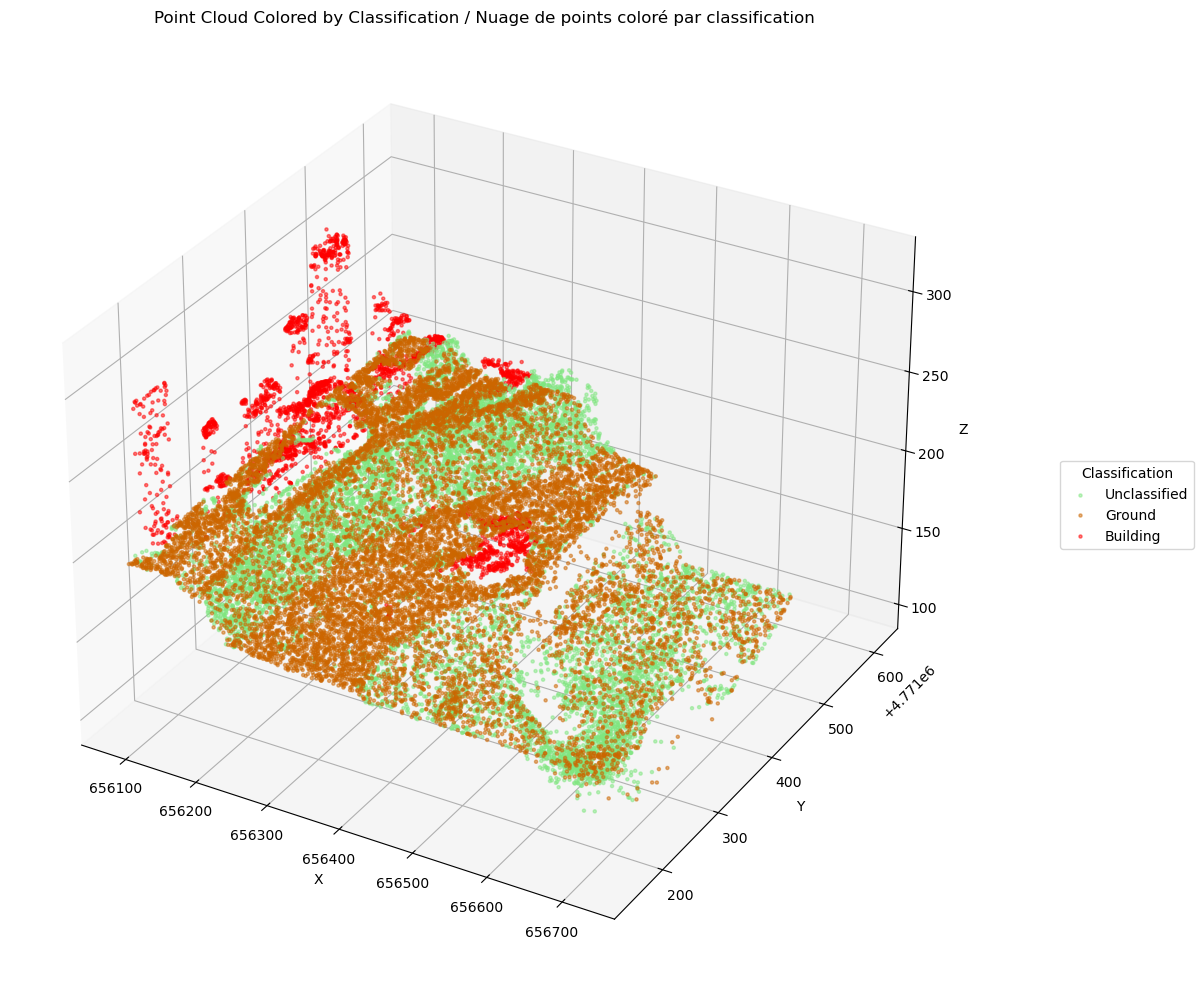

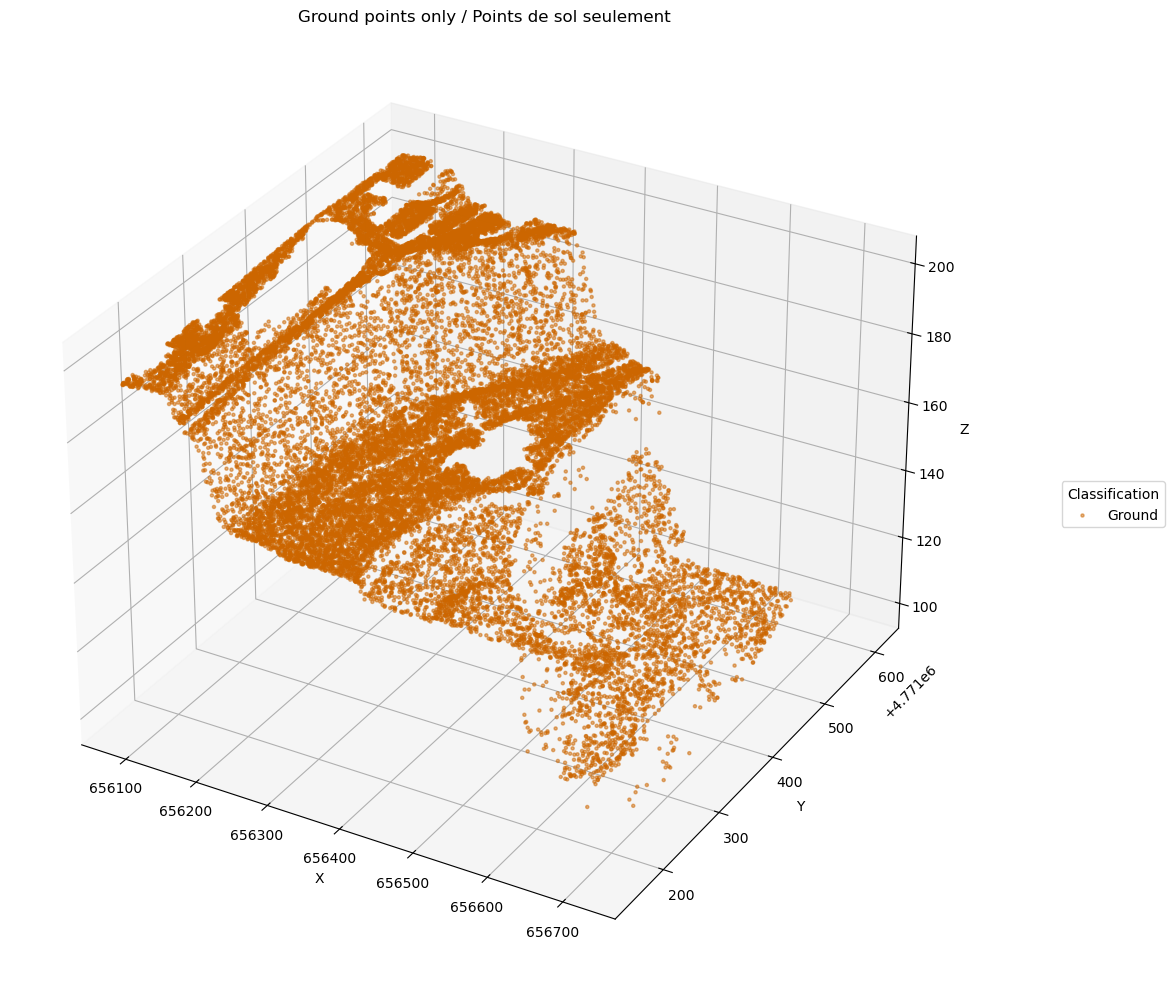

In [6]:
# Conserver les points des classes : non classés (1), sol (2), bâtiments (6), eau (9)
pipeline_allpoints = create_read_pdal_pipeline(copc_laz, all_points_laz, bbox=aoi_bbox, classes=[1, 2, 6, 9])
pipeline_allpoints.execute()
points = pipeline_allpoints.arrays[0]
plot1 = create_plot('Point Cloud Colored by Classification | Nuage de points coloré par classification', points, max_points=25000)
plot1.show()


# Conserver uniquement les points de sol (2) et d’eau (9) pour la création du MNE
pipeline_ground_points = create_read_pdal_pipeline(copc_laz, ground_laz, bbox=aoi_bbox, classes=[2, 9])
pipeline_ground_points.execute()
ground_points = pipeline_ground_points.arrays[0]
plot2 = create_plot('Ground points only | Points de sol seulement', ground_points, max_points=25000)
plot2.show()

<a id="creer-mne"></a>
## 6) Créer le MNE au format GeoTIFF

Pour cette étape, nous utilisons l'objet `ground_points`, qui contient le tableau des points représentant la surface. Nous le passons à la méthode `create_dem_pipeline`, qui construit un pipeline pour convertir les points en un format raster (MNE). Pour visualiser le résultat, nous générons un graphique du raster résultant.

Note : Le résultat contient des zones sans données (NoData). Celles-ci correspondent aux régions où aucun point de sol ou d’eau n’était disponible. Si une couverture complète de la surface est nécessaire, des outils comme [`gdal_fillnodata`](https://gdal.org/en/stable/programs/gdal_fillnodata.html) peuvent être utilisés pour interpoler et remplir ces zones sans données.

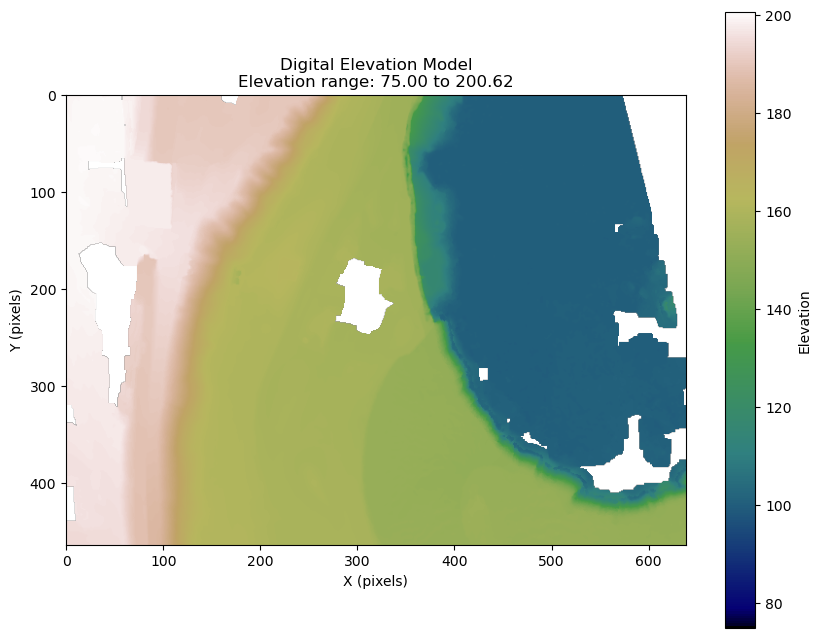

In [7]:
# Créer un pipeline PDAL pour générer un MNE à partir du tableau de points de sol filtrés
dem_pipeline = create_dem_pipeline(ground_points)

# Exécuter le pipeline pour générer et enregistrer le MNE au format GeoTIFF
dem_pipeline.execute()

# Afficher le MNE résultant
fig, ax = plot_dem('dem.tif', cmap = 'gist_earth')
plt.show()